In [1]:
!pip install pyspark
!pip install spark-nlp

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 kB 3.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [2]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, ArrayType

from pyspark.ml import Pipeline, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.feature import Bucketizer

spark = SparkSession.builder.appName('NLP').getOrCreate()
spark

23/06/25 20:47:18 WARN Utils: Your hostname, vadim-hp resolves to a loopback address: 127.0.1.1; using 192.168.100.189 instead (on interface eno1)
23/06/25 20:47:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/25 20:47:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymongo import MongoClient
db = MongoClient(host='localhost', port=27017)['news_classification']

[nltk_data] Downloading package punkt to /home/vadim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import json
from datetime import datetime

In [ ]:
# read franchise

In [228]:
tokens_df = pd.DataFrame(franchise)[['name', 'slug', 'games_count', "rating_count", "games_titles_tokens"]]
tokens_df = tokens_df.rename(columns={"name": "tag_name", "slug": "tag_slug"})

In [229]:
tokens_df1 = tokens_df.explode('games_titles_tokens', ignore_index=True)

In [230]:
tokens_df1.head()

,tag_name,tag_slug,games_count,rating_count,games_titles_tokens
0,Pac-Man,pac-man,219,161,"{'value': 'street fighter x tekken', 'tokens':..."
1,Pac-Man,pac-man,219,161,"{'value': 'pac-man world rally', 'tokens': ['p..."
2,Pac-Man,pac-man,219,161,"{'value': 'pac-man', 'tokens': ['pac-man'], 'l..."
3,Pac-Man,pac-man,219,161,"{'value': 'ms. pac-man: maze madness', 'tokens..."
4,Pac-Man,pac-man,219,161,"{'value': 'pac-man fever', 'tokens': ['pac-man..."


In [231]:
tokens_df2 = tokens_df1.join(pd.json_normalize(tokens_df1.games_titles_tokens)).drop(labels='games_titles_tokens', axis=1)

In [232]:
tokens_df2.head()

,tag_name,tag_slug,games_count,rating_count,value,tokens,l
0,Pac-Man,pac-man,219,161,street fighter x tekken,"[street, fighter, x, tekken]",4
1,Pac-Man,pac-man,219,161,pac-man world rally,"[pac-man, world, rally]",3
2,Pac-Man,pac-man,219,161,pac-man,[pac-man],1
3,Pac-Man,pac-man,219,161,ms. pac-man: maze madness,"[ms., pac-man, :, maze, madness]",5
4,Pac-Man,pac-man,219,161,pac-man fever,"[pac-man, fever]",2


In [233]:
tokens_df2['value'] = tokens_df2['value'].map(lambda x: x.replace('é', 'e') if "é" in x else x)
tokens_df2['tokens'] = tokens_df2['tokens'].map(lambda x: [i.replace('é', 'e') if "é" in i else i for i in x])

In [234]:
tokens_df2['value'] = tokens_df2['value'].map(lambda x: x.replace('iv', '4') if 'iv' in x else x)
tokens_df2['tokens'] = tokens_df2['tokens'].map(lambda x: [i.replace('iv', '4') if 'iv' in i else i for i in x])
tokens_df2['value'] = tokens_df2['value'].map(lambda x: x.replace('iii', '3') if 'iii' in x else x)
tokens_df2['tokens'] = tokens_df2['tokens'].map(lambda x: [i.replace('iii', '3') if 'iii' in i else i for i in x])
tokens_df2['value'] = tokens_df2['value'].map(lambda x: x.replace('ii', '2') if 'ii' in x else x)
tokens_df2['tokens'] = tokens_df2['tokens'].map(lambda x: [i.replace('ii', '2') if 'ii' in i else i for i in x])

In [236]:
tokens_df3 = tokens_df2.rename(columns={"value": "game_name", "tokens": "game_tokens", "l": "length"}) 

In [237]:
tokens_df3.sort_values('games_count')

,tag_name,tag_slug,games_count,rating_count,game_name,game_tokens,length
10838,Grey's Anatomy,grey-s-anatomy,1,1,grey's anatomy: the video game,"[grey, 's, anatomy, :, the, video, game]",7
1302,PewDiePie,pewdiepie,1,2,pewdiepie: legend of the brofist,"[pewdiepie, :, legend, of, the, brofist]",6
1709,Valkyrie Drive,valkyrie-drive,1,7,valkyrie dr4e: bhikkhuni,"[valkyrie, dr4e, :, bhikkhuni]",4
3007,Ogre,ogre,1,1,ogre,[ogre],1
3010,Young Justice,young-justice,1,1,young justice: legacy,"[young, justice, :, legacy]",4
...,...,...,...,...,...,...,...
12021,Disney,disney,477,263,disney's beauty and the beast: a board game ad...,"[disney, 's, beauty, and, the, beast, :, a, bo...",11
12022,Disney,disney,477,263,dance dance revolution gb disney mix,"[dance, dance, revolution, gb, disney, mix]",6
12023,Disney,disney,477,263,mickey's 123's: the big surprise party,"[mickey, 's, 123, 's, :, the, big, surprise, p...",9
12015,Disney,disney,477,263,disney's donald duck advance,"[disney, 's, donald, duck, advance]",5


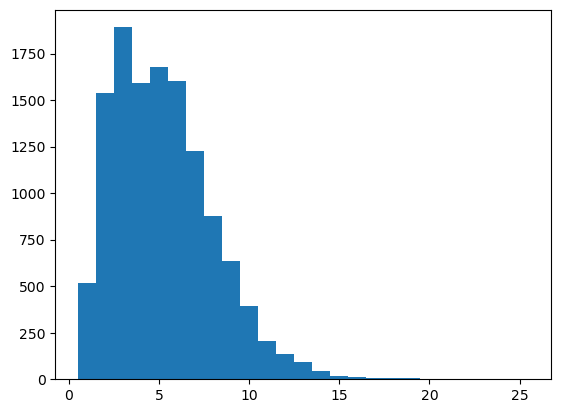

In [239]:
x, y = np.unique(tokens_df3['length'], return_counts=True)
fig, ax = plt.subplots()
ax.bar(x, y, width=1)
plt.show()

In [240]:
clean_tokens = tokens_df3[['tag_slug', 'game_name', 'game_tokens', 'length']].to_json(orient='records')
clean_tokens = json.loads(clean_tokens)
clean_tokens[0]

{'tag_slug': 'pac-man',
 'game_name': 'street fighter x tekken',
 'game_tokens': ['street', 'fighter', 'x', 'tekken'],
 'length': 4}

In [242]:
tokens_df3[tokens_df3['tag_slug'] == 'diablo']

,tag_name,tag_slug,games_count,rating_count,game_name,game_tokens,length
3910,Diablo,diablo,17,82,diablo 3,"[diablo, 3]",2
3911,Diablo,diablo,17,82,diablo,[diablo],1
3912,Diablo,diablo,17,82,diablo 2,"[diablo, 2]",2
3913,Diablo,diablo,17,82,diablo 2: lord of destruction,"[diablo, 2, :, lord, of, destruction]",6
3914,Diablo,diablo,17,82,diablo 3: reaper of souls,"[diablo, 3, :, reaper, of, souls]",6
3915,Diablo,diablo,17,82,diablo: hellfire,"[diablo, :, hellfire]",3
3916,Diablo,diablo,17,82,diablo 3: rise of the necromancer,"[diablo, 3, :, rise, of, the, necromancer]",7
3917,Diablo,diablo,17,82,diablo: battle chest,"[diablo, :, battle, chest]",4
3918,Diablo,diablo,17,82,diablo 3: reaper of souls - ultimate evil edition,"[diablo, 3, :, reaper, of, souls, -, ultimate,...",10
3919,Diablo,diablo,17,82,diablo 3: eternal collection,"[diablo, 3, :, eternal, collection]",5


In [ ]:
json_array = tokens_df3.to_json(orient='records')
db['Tags'].insert_many(json_array)